In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE

sns.set_style('whitegrid')


In [19]:
!curl -L -o kc1.csv "https://raw.githubusercontent.com/ApoorvaKrisna/NASA-promise-dataset-repository/main/kc1.csv"
import pandas as pd
df = pd.read_csv('kc1.csv')
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150k  100  150k    0     0   703k      0 --:--:-- --:--:-- --:--:--  704k


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,21378.61,...,65,10,6,0,18.0,25.0,107.0,64.0,21.0,True
3,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,11436.73,...,37,2,5,0,16.0,28.0,89.0,52.0,15.0,True
4,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,2381.95,...,21,0,2,0,11.0,10.0,41.0,17.0,5.0,True


In [20]:

candidates = [c for c in df.columns if c.lower() in ('defects')]

# If candidate list is empty, inspect unique values of last column
if not candidates:
    print("Unique values in last column ({}):".format(df.columns[-1]))
    print(df.iloc[:, -1].unique())

# Quick class balance (replace 'defects' below if actual target different)
target = 'defects' if 'defects' in df.columns else (candidates[0] if candidates else df.columns[-1])
print("Using target column:", target)
print(df[target].value_counts(dropna=False))


Using target column: defects
defects
False    1783
True      326
Name: count, dtype: int64


In [21]:
# Separate X, y
X = df.drop(columns=[target])
y = df[target]

# Convert string labels to integers if target is non-numeric
if y.dtype == 'object' or str(y.dtype).startswith('category'):
    y = LabelEncoder().fit_transform(y.astype(str))

# Encode categorical features
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical features to encode:", cat_cols)
for c in cat_cols:
    X[c] = LabelEncoder().fit_transform(X[c].astype(str))

# Fill missing numeric values with median
num_cols = X.select_dtypes(include=[np.number]).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())


if 'id' in X.columns.str.lower():
    # (case sensitive check)
    X = X.loc[:, ~X.columns.str.lower().eq('id')]

# Scale numeric features (recommended for LR)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
print("Preprocessing done. Features shape:", X_scaled.shape)


Categorical features to encode: []
Preprocessing done. Features shape: (2109, 21)


In [22]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)
print("After SMOTE class counts:\n", pd.Series(y_res).value_counts())

# stratify split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

After SMOTE class counts:
 defects
False    1783
True     1783
Name: count, dtype: int64
Train shape: (2852, 21) Test shape: (714, 21)


In [23]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n=== {name} ===")
    print("Accuracy:", round(acc, 4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))


=== Logistic Regression ===
Accuracy: 0.7339
Confusion matrix:
 [[264  93]
 [ 97 260]]
              precision    recall  f1-score   support

       False       0.73      0.74      0.74       357
        True       0.74      0.73      0.73       357

    accuracy                           0.73       714
   macro avg       0.73      0.73      0.73       714
weighted avg       0.73      0.73      0.73       714


=== Decision Tree ===
Accuracy: 0.8585
Confusion matrix:
 [[298  59]
 [ 42 315]]
              precision    recall  f1-score   support

       False       0.88      0.83      0.86       357
        True       0.84      0.88      0.86       357

    accuracy                           0.86       714
   macro avg       0.86      0.86      0.86       714
weighted avg       0.86      0.86      0.86       714


=== Random Forest ===
Accuracy: 0.9216
Confusion matrix:
 [[323  34]
 [ 22 335]]
              precision    recall  f1-score   support

       False       0.94      0.90      

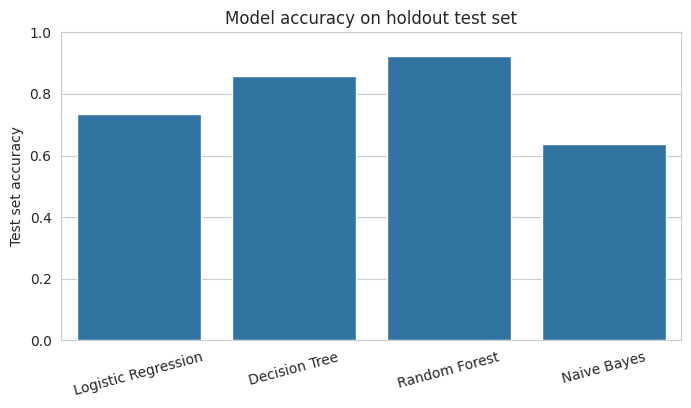

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("Test set accuracy")
plt.ylim(0,1)
plt.title("Model accuracy on holdout test set")
plt.xticks(rotation=15)
plt.show()

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(model, X_res, y_res, cv=kf, scoring='accuracy', n_jobs=-1)
    cv_scores[name] = (scores.mean(), scores.std())
    print(f"{name}  | mean = {scores.mean():.4f}  std = {scores.std():.4f}")

In [ ]:
names = list(cv_scores.keys())
means = [cv_scores[n][0] for n in names]
stds = [cv_scores[n][1] for n in names]

plt.figure(figsize=(8,4))
sns.barplot(x=names, y=means)
plt.errorbar(x=range(len(names)), y=means, yerr=stds, fmt='none', capsize=5)
plt.ylim(0,1)
plt.title("10-fold CV mean accuracy (with std error bars)")
plt.xticks(rotation=15)
plt.show()

In [ ]:
rf = models['Random Forest']
if hasattr(rf, "feature_importances_"):
    fi = pd.Series(rf.feature_importances_, index=X_res.columns).sort_values(ascending=False)
    display(fi.head(20))
    # plot top 15
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.head(15).values, y=fi.head(15).index)
    plt.title("Top 15 feature importances (Random Forest)")
    plt.show()
else:
    print("Random Forest not available or not trained.")

In [ ]:
import joblib
joblib.dump(models['Random Forest'], 'rf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
# save results summary
pd.DataFrame({
    'model': list(results.keys()),
    'test_accuracy': list(results.values()),
    'cv_mean_accuracy': [cv_scores[n][0] for n in names],
    'cv_std': [cv_scores[n][1] for n in names]
}).to_csv('model_summary.csv', index=False)
print("Saved rf_model.joblib, scaler.joblib and model_summary.csv")